In [6]:
# 读文件
path = r'./Austen_Emma.txt' #文件的路径
fn = open(path,encoding='utf-8') #打开文件
string_data = fn.read() #读取文件
fn.close() #关闭文件

#文本预处理，去掉文本中的标点符号
import re
pattern = re.compile(u'\t|\.|-|:|;|\)|\(|\?|"') # 定义正则表达式匹配模式
string_data = re.sub(pattern, '', string_data) # 将符合模式的字符去除

In [8]:
#词形还原处理

import nltk
def find_pos(text):
    pos = nltk.pos_tag(nltk.word_tokenize(text),tagset='universal')
    tags = []
    for i in pos:
        if i[1][0].lower()=='a':
            tags.append('a')
        elif i[1][0].lower()=='r':
            tags.append('r')
        elif i[1][0].lower()=='v':
            tags.append('v')
        else:
            tags.append('n')
    return tags

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
tokens = nltk.word_tokenize(string_data.lower())
tags = find_pos(string_data)
lemma_words = []
for i in range(0,len(tokens)):
    lemma_words.append(wnl.lemmatize(tokens[i],tags[i]))
string_data2 = " ".join(lemma_words)


In [9]:
#加载停用词
from nltk.corpus import stopwords
remove_words = stopwords.words('english')
remove_words = remove_words+['get','however','otherwise','thereto'] #添加自己的定用词


In [11]:
##信息贡献度提取主题词
from gensim.summarization import mz_keywords
keywords = mz_keywords(string_data2,scores=True,threshold=0.0002)
keywordsList6 = []
valueList6 = []
for word,value in keywords:
    if word not in remove_words:
        keywordsList6.append(word)
        valueList6.append(int(value*10000))
combine6 = sorted(zip(keywordsList6,valueList6))                  

C:\ProgramData\Anaconda3\lib\site-packages\gensim\summarization\mz_entropy.py:65: RuntimeWarning: divide by zero encountered in log2
  log_p = np.log2(p)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\summarization\mz_entropy.py:66: RuntimeWarning: invalid value encountered in multiply
  h = np.nan_to_num(p * log_p).sum(axis=0)


In [12]:
#定义用于创建语义网络的词汇数量

import collections
import pandas as pd

num = 60
word_counts = collections.Counter(dict(combine6))
word_counts_top = word_counts.most_common(num)
word = pd.DataFrame(word_counts_top,columns=['关键词','信息贡献度'])
print(word)

          关键词  信息贡献度
0     harriet     26
1       elton     20
2        jane     19
3      weston     17
4        miss     16
5          mr     16
6     fairfax     14
7   churchill     11
8   knightley     10
9      letter     10
10     martin     10
11      frank      9
12        say      9
13      bates      8
14       dear      7
15         go      7
16      perry      7
17      would      7
18   campbell      6
19       cole      6
20      dance      6
21        man      6
22      shall      6
23       john      5
24      marry      5
25        may      5
26      quite      5
27      smith      5
28          u      5
29  woodhouse      5
30   carriage      4
31      child      4
32       come      4
33      dixon      4
34       emma      4
35     father      4
36      first      4
37    goddard      4
38       hear      4
39   isabella      4
40       know      4
41     mother      4
42       read      4
43     taylor      4
44      think      4
45       walk      4
46      write

In [13]:
#获取单词数量对应的矩阵

import numpy as np
word_T = pd.DataFrame(word.values.T,columns=word.iloc[:,0])

net = pd.DataFrame(np.mat(np.zeros((num,num))),columns=word.iloc[:,0])

cleanList = dict([(w,v) for w,v in combine6 if w not in remove_words])
word_counts2 = collections.Counter(cleanList)
word_counts_top2 = word_counts2.most_common(num)
word2 = pd.DataFrame(word_counts_top2)
word2_T = pd.DataFrame(word2.values.T,columns=word2.iloc[:,0])
relation = list(0 for x in range(num))

#查看该段最高频的词是否在总的最高频的词表中
for j in range(num):
    for p in range(len(word2)):
        if word.iloc[j,0] == word2.iloc[p,0]:
            relation[j] = 1
            break

#对于同段落内出现的最高频次，根据算出频次数加到语义关联矩阵的相应位置
for j in range(num):
    if relation[j] == 1:
        for q in range(num):
            if relation[q]==1:
                net.iloc[j,q] = net.iloc[j,q] + word2_T.loc[1,word_T.iloc[0,q]]

#构建最终用于可视化的数据结构
import networkx as nx
G = nx.Graph()
for i in range(num):
    for j in range(i,num):
        G.add_weighted_edges_from([(word.iloc[i,0],word.iloc[j,0],net.iloc[i,j])])
print(G.edges())

[('harriet', 'harriet'), ('harriet', 'elton'), ('harriet', 'jane'), ('harriet', 'weston'), ('harriet', 'miss'), ('harriet', 'mr'), ('harriet', 'fairfax'), ('harriet', 'churchill'), ('harriet', 'knightley'), ('harriet', 'letter'), ('harriet', 'martin'), ('harriet', 'frank'), ('harriet', 'say'), ('harriet', 'bates'), ('harriet', 'dear'), ('harriet', 'go'), ('harriet', 'perry'), ('harriet', 'would'), ('harriet', 'campbell'), ('harriet', 'cole'), ('harriet', 'dance'), ('harriet', 'man'), ('harriet', 'shall'), ('harriet', 'john'), ('harriet', 'marry'), ('harriet', 'may'), ('harriet', 'quite'), ('harriet', 'smith'), ('harriet', 'u'), ('harriet', 'woodhouse'), ('harriet', 'carriage'), ('harriet', 'child'), ('harriet', 'come'), ('harriet', 'dixon'), ('harriet', 'emma'), ('harriet', 'father'), ('harriet', 'first'), ('harriet', 'goddard'), ('harriet', 'hear'), ('harriet', 'isabella'), ('harriet', 'know'), ('harriet', 'mother'), ('harriet', 'read'), ('harriet', 'taylor'), ('harriet', 'think'), ('

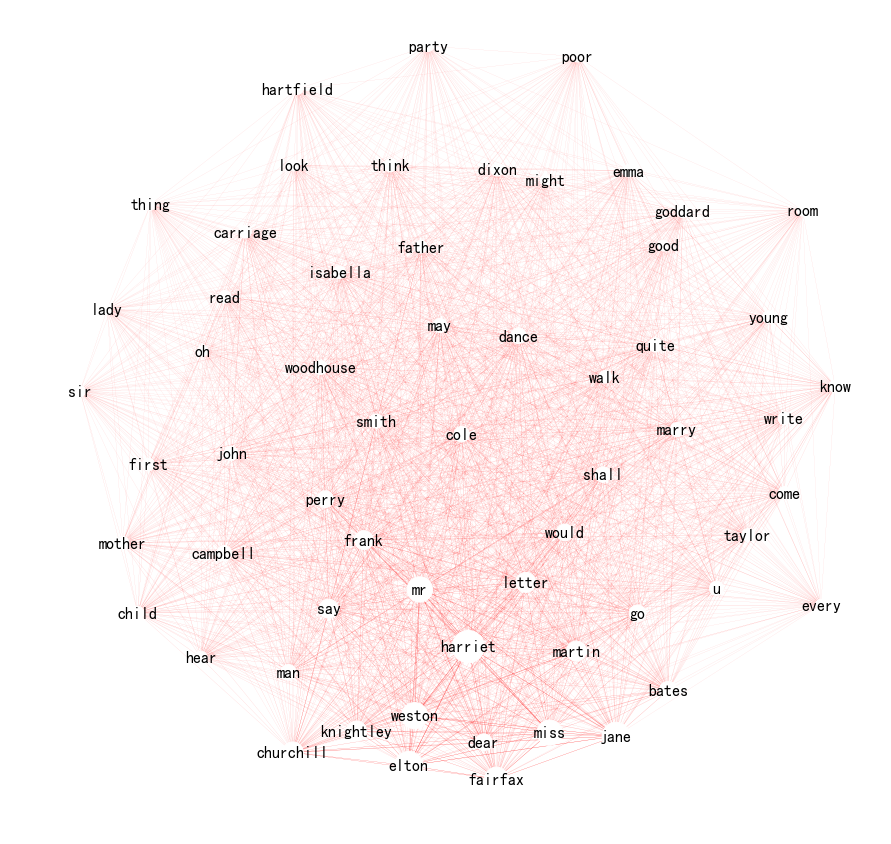

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
plt.rcParams['font.sans-serif'] = ['SimHei']   # 用来正常显示中文标签
nx.draw_networkx(G,
                pos = nx.spring_layout(G),
                width = [float(v['weight']/80) for (r,c,v) in G.edges(data=True)],
                edge_color = 'red',
                node_size = [float(net.iloc[i,i]*40) for i in np.arange(60)],
                node_color='white',
                node_shape='o',
                font_size=16,
                fonts='times new roman',
                style='solid')
plt.axis('off')
plt.show()